In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import gelu
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from data import DataProvider

In [2]:
provider = DataProvider()
raw_df = provider.read_excel()
scaled_df = provider.scale_data(raw_df)

C:\Users\dimaherez\AppData\Local\Temp\ipykernel_3308\3921685181.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


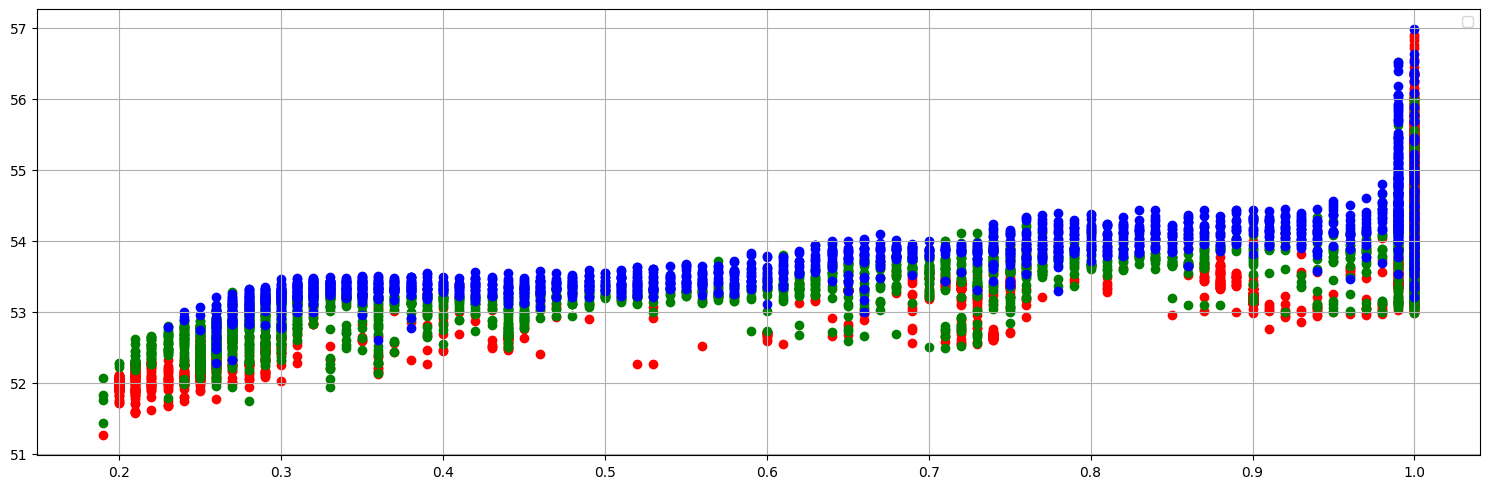

In [3]:
charging_df_0_2 = provider.get_charging_data(scaled_df, 0, -2)
charging_df_2_8 = provider.get_charging_data(scaled_df, -2, -8)
charging_df_8_14 = provider.get_charging_data(scaled_df, -8, -14)

charging_dfs = [charging_df_0_2, charging_df_2_8, charging_df_8_14]
rangesStrings = ["0A - 2A", "2A - 8A", "8A - 14A"]

plt.figure(figsize=(15, 5))

plt.scatter(
        charging_df_0_2["SoC"], 
        charging_df_0_2["Battery Voltage(V)"], 
        marker='o',  
        color='red'
    )

plt.scatter(
        charging_df_2_8["SoC"], 
        charging_df_2_8["Battery Voltage(V)"], 
        marker='o',  
        color='green'
    )

plt.scatter(
        charging_df_8_14["SoC"], 
        charging_df_8_14["Battery Voltage(V)"], 
        marker='o',  
        color='blue'
    )

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
def build_model(input_dim, hidden_layers, activation='relu', output_activation=None):
    model = Sequential()
    
    # Add hidden layers
    for units in hidden_layers:
        model.add(Dense(units, activation=activation, input_shape=(input_dim,)))
        input_dim = None  # Only needed for first layer
    
    # Output layer
    model.add(Dense(1, activation=output_activation))  # For regression, use None or 'linear'
    
    return model

# Leaky ReLU model (requires custom layer)
def build_leaky_model(input_dim):
    model = Sequential([
        Dense(32, input_shape=(input_dim,)),
        LeakyReLU(alpha=0.01),
        Dense(16),
        LeakyReLU(alpha=0.01),
        Dense(1)
    ])
    return model

models = {
    "ReLU": lambda dim: build_model(dim, [32, 16], activation='relu'),
    "Tanh": lambda dim: build_model(dim, [32, 16], activation='tanh'),
    "Swish": lambda dim: build_model(dim, [32, 16], activation='swish'),
    "GELU": lambda dim: build_model(dim, [32, 16], activation=gelu),
    "LeakyReLU": build_leaky_model
}


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [5]:


def run_training_benchmark(charging_dfs, models, rangesStrings):
    """
    Trains and evaluates multiple models on multiple datasets efficiently.

    Returns:
        A dictionary containing the results and trained artifacts for each experiment.
    """
    benchmark_results = {}
    BATCH_SIZE = 16

    for i, df in enumerate(charging_dfs):
        print(f"\n⚡ Processing Charging Range {i+1}: Current ∈ [{df['Battery Current(A)'].min():.1f}, {df['Battery Current(A)'].max():.1f}] A")

        # 1. Prepare and split data CORRECTLY
        X = df[["SoC"]].values
        y = df["Battery Voltage(V)"].values.reshape(-1, 1)
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

        # 2. Scale data after splitting to prevent data leakage
        x_scaler = MinMaxScaler()
        X_train = x_scaler.fit_transform(X_train_raw)
        X_test = x_scaler.transform(X_test_raw)

        y_scaler = MinMaxScaler()
        y_train = y_scaler.fit_transform(y_train_raw)
        y_test = y_scaler.transform(y_test_raw)

        # 3. Create efficient tf.data pipelines
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        # Inner loop for different models
        for name, builder in models.items():
            print(f"  -> Training model: {name}")

            # 4. Set up callbacks for efficient training
            # Stop training if validation loss doesn't improve for 15 epochs
            early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

            # Build and compile a fresh model
            model = builder(X_train.shape[1])
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])

            # 5. Train the model
            history = model.fit(
                train_ds,
                epochs=200, # Max epochs; early stopping will likely finish sooner
                validation_data=test_ds,
                callbacks=[early_stopping],
                verbose=0 # Set to 1 for progress bars
            )

            # 6. Evaluate the BEST model on the test set
            y_pred_scaled = model.predict(X_test)
            y_pred = y_scaler.inverse_transform(y_pred_scaled)

            # Calculate metrics on the original scale
            mse = mean_squared_error(y_test_raw, y_pred)
            mae = mean_absolute_error(y_test_raw, y_pred)
            r2 = r2_score(y_test_raw, y_pred)
            
            # Store results
            key = f"{rangesStrings[i]}_{name}"
            benchmark_results[key] = {
                "model": model,
                "x_scaler": x_scaler,
                "y_scaler": y_scaler,
                "history": history.history,
                "mse": mse,
                "mae": mae,
                "r2": r2,
                "x_test": X_test_raw,
                "y_pred": y_pred,
                "y_true": y_test_raw,
                "df_original": df,
                "epochs_trained": len(history.history['loss'])
            }
            print(f"  ✅ Done. MAE: {mae:.4f} V | R²: {r2:.4f} | Epochs: {len(history.history['loss'])}")

    return benchmark_results

benchmark_results = run_training_benchmark(charging_dfs, models, rangesStrings)


⚡ Processing Charging Range 1: Current ∈ [-2.0, 0.0] A
  -> Training model: ReLU


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  ✅ Done. MAE: 0.3948 V | R²: 0.6449 | Epochs: 118
  -> Training model: Tanh


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  ✅ Done. MAE: 0.4035 V | R²: 0.6217 | Epochs: 44
  -> Training model: Swish


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  ✅ Done. MAE: 0.4080 V | R²: 0.6304 | Epochs: 94
  -> Training model: GELU


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  ✅ Done. MAE: 0.4043 V | R²: 0.6303 | Epochs: 72
  -> Training model: LeakyReLU


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  ✅ Done. MAE: 0.3913 V | R²: 0.6469 | Epochs: 163

⚡ Processing Charging Range 2: Current ∈ [-8.0, -2.0] A
  -> Training model: ReLU


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  ✅ Done. MAE: 0.2268 V | R²: 0.6957 | Epochs: 164
  -> Training model: Tanh


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  ✅ Done. MAE: 0.2381 V | R²: 0.6796 | Epochs: 33
  -> Training model: Swish


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  ✅ Done. MAE: 0.2367 V | R²: 0.6814 | Epochs: 55
  -> Training model: GELU


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  ✅ Done. MAE: 0.2333 V | R²: 0.6894 | Epochs: 119
  -> Training model: LeakyReLU


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  ✅ Done. MAE: 0.2292 V | R²: 0.6948 | Epochs: 26

⚡ Processing Charging Range 3: Current ∈ [-14.0, -8.0] A
  -> Training model: ReLU


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  ✅ Done. MAE: 0.2101 V | R²: 0.6824 | Epochs: 22
  -> Training model: Tanh


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  ✅ Done. MAE: 0.2013 V | R²: 0.6935 | Epochs: 52
  -> Training model: Swish


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  ✅ Done. MAE: 0.2025 V | R²: 0.6929 | Epochs: 64
  -> Training model: GELU


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  ✅ Done. MAE: 0.2038 V | R²: 0.6930 | Epochs: 71
  -> Training model: LeakyReLU


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  ✅ Done. MAE: 0.1948 V | R²: 0.7012 | Epochs: 24


  -> MAE of Model vs. Smoothed Baseline: 0.1479 V
  -> MSE of Model vs. Smoothed Baseline: 0.042711 V²
  -> R2 of Model vs. Smoothed Baseline: 0.788027 V²


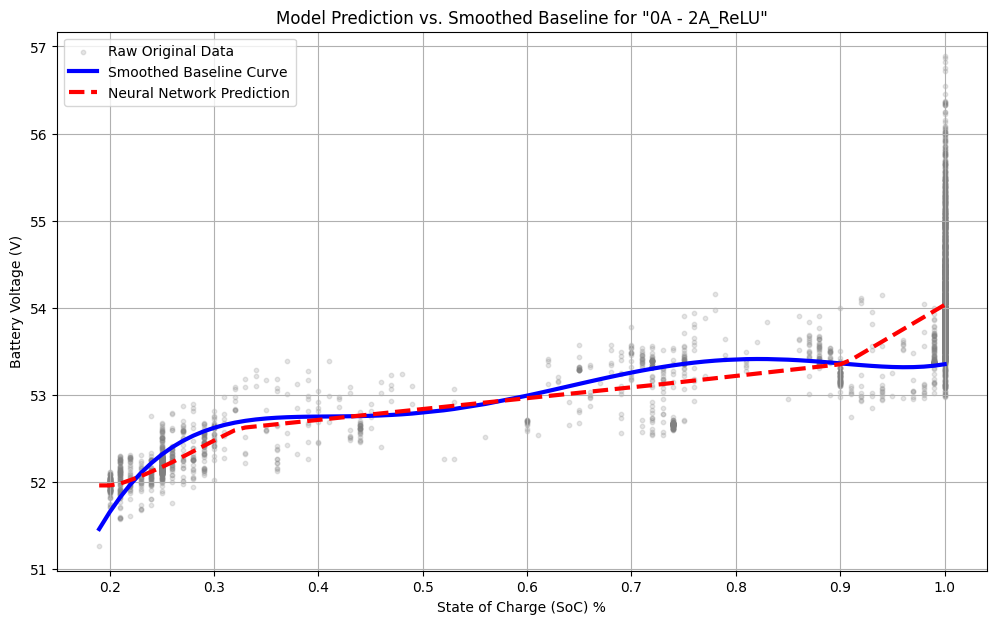

  -> MAE of Model vs. Smoothed Baseline: 0.2092 V
  -> MSE of Model vs. Smoothed Baseline: 0.078658 V²
  -> R2 of Model vs. Smoothed Baseline: 0.609623 V²


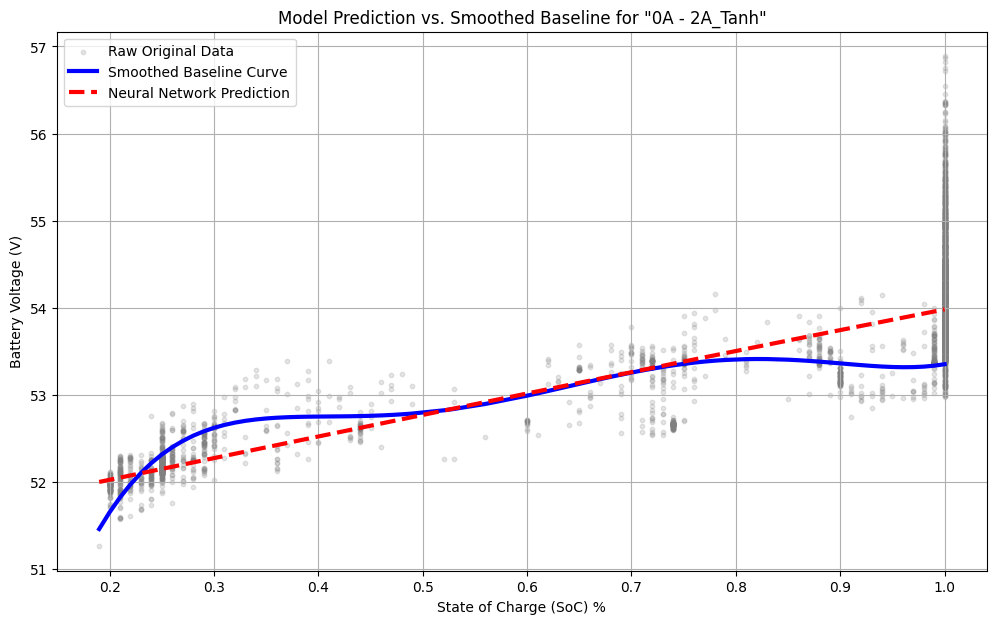

  -> MAE of Model vs. Smoothed Baseline: 0.2607 V
  -> MSE of Model vs. Smoothed Baseline: 0.093589 V²
  -> R2 of Model vs. Smoothed Baseline: 0.535520 V²


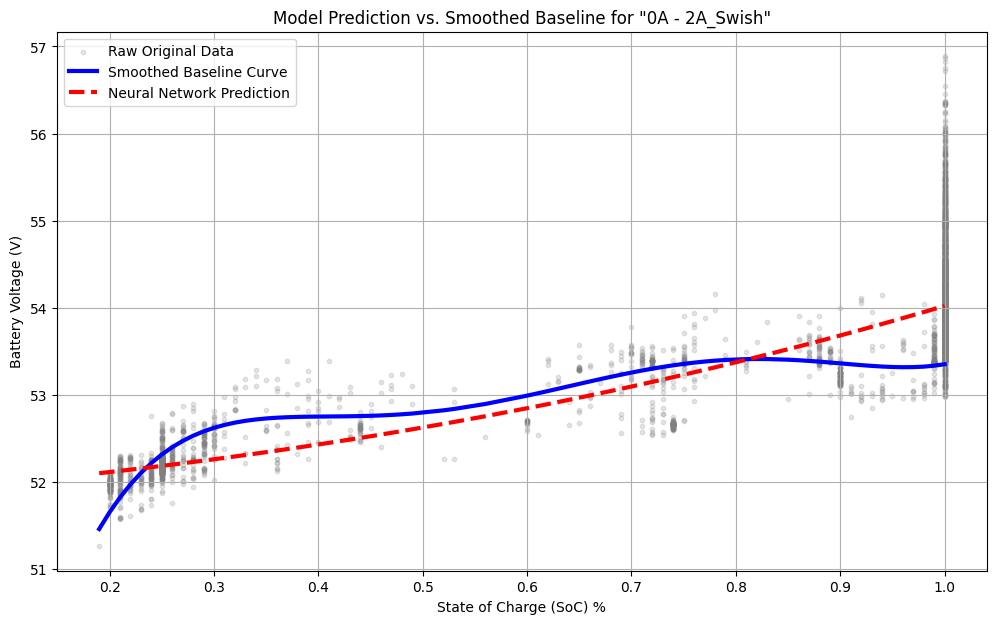

  -> MAE of Model vs. Smoothed Baseline: 0.2541 V
  -> MSE of Model vs. Smoothed Baseline: 0.089067 V²
  -> R2 of Model vs. Smoothed Baseline: 0.557965 V²


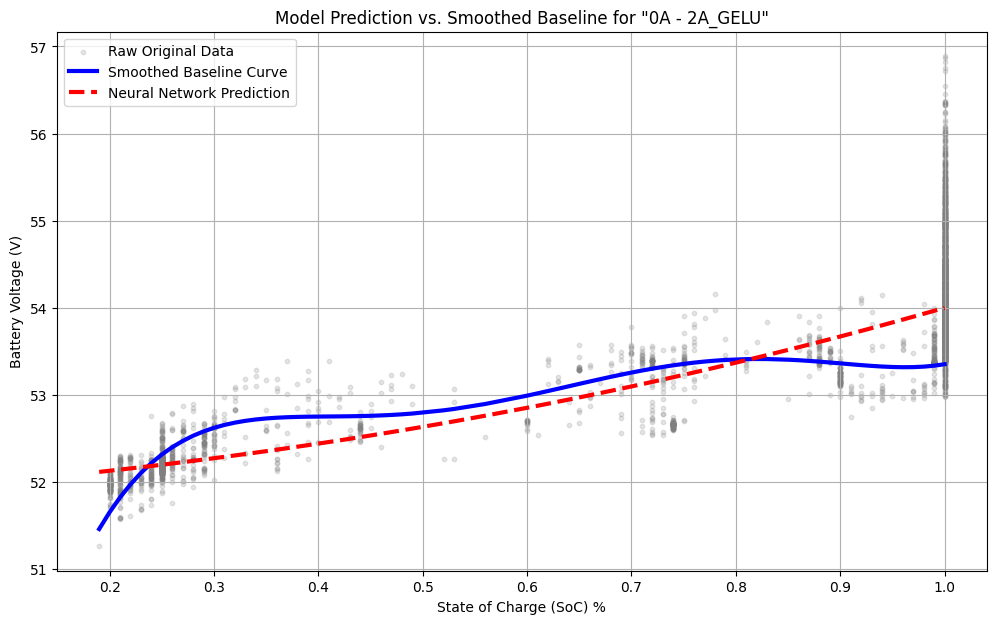

  -> MAE of Model vs. Smoothed Baseline: 0.1408 V
  -> MSE of Model vs. Smoothed Baseline: 0.045807 V²
  -> R2 of Model vs. Smoothed Baseline: 0.772660 V²


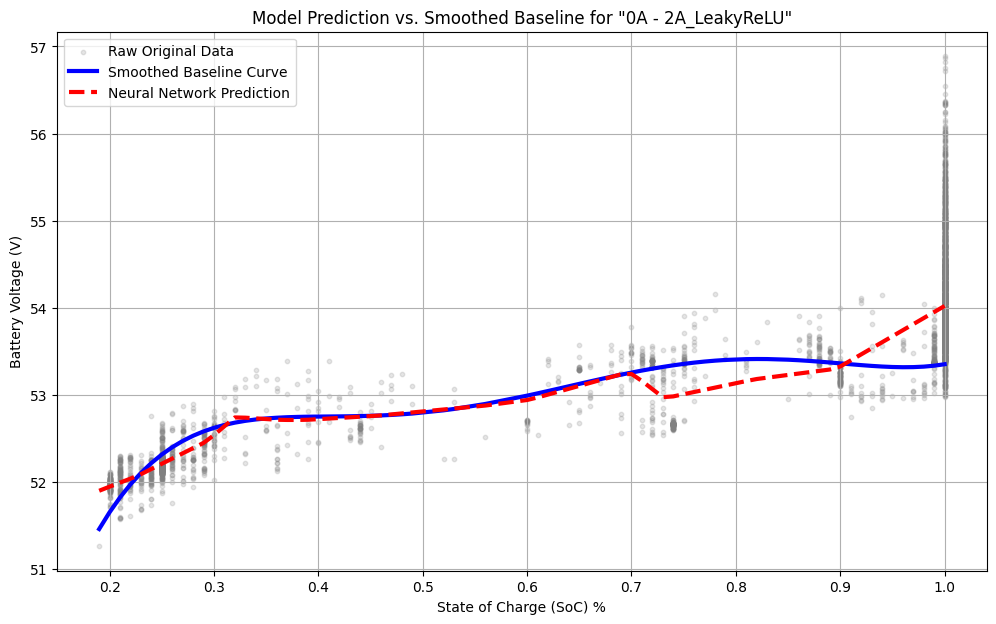

  -> MAE of Model vs. Smoothed Baseline: 0.0524 V
  -> MSE of Model vs. Smoothed Baseline: 0.004956 V²
  -> R2 of Model vs. Smoothed Baseline: 0.973245 V²


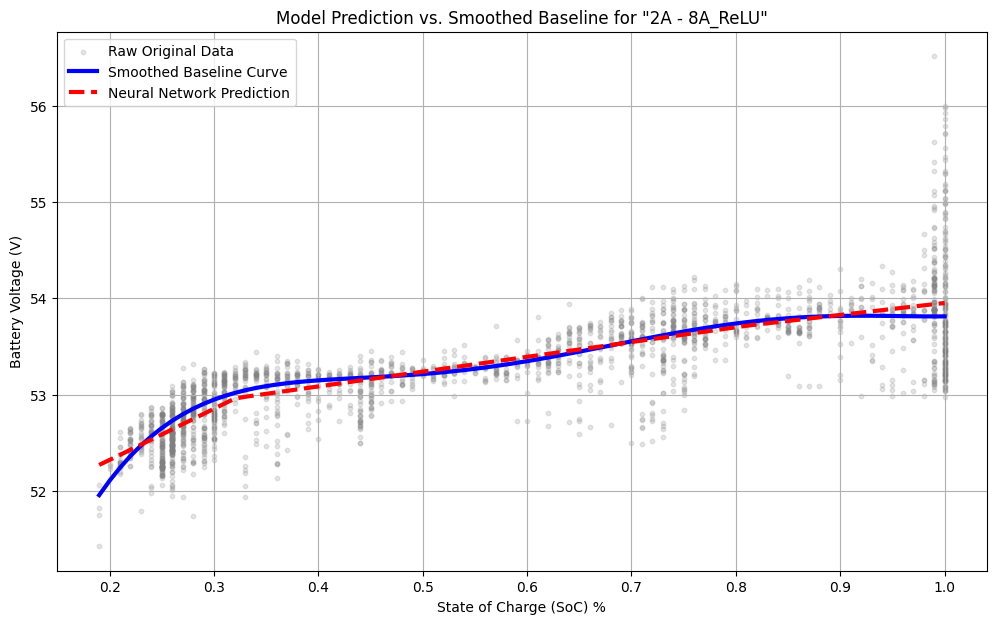

  -> MAE of Model vs. Smoothed Baseline: 0.0801 V
  -> MSE of Model vs. Smoothed Baseline: 0.015072 V²
  -> R2 of Model vs. Smoothed Baseline: 0.918628 V²


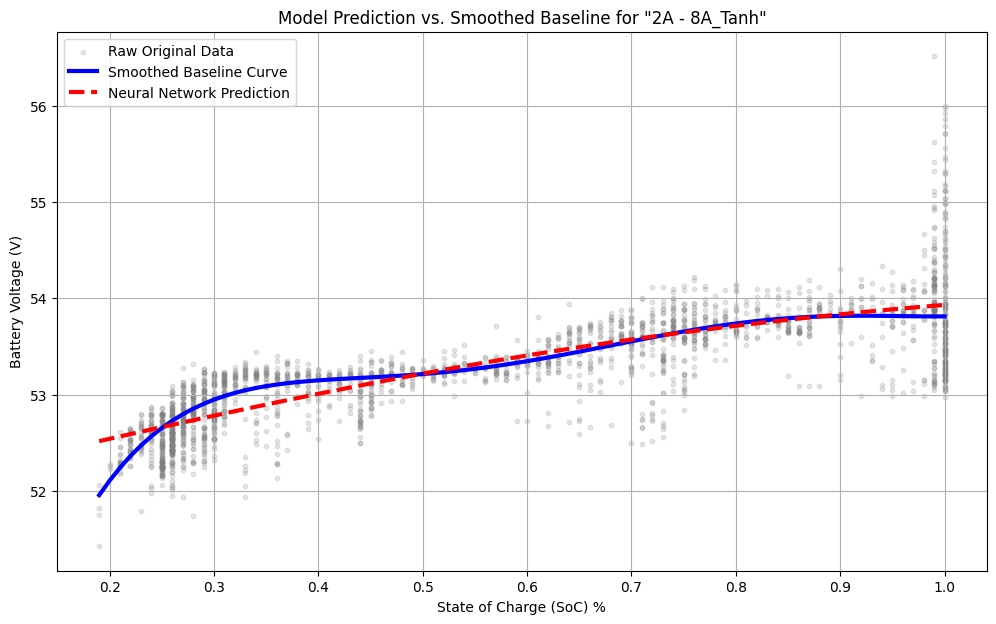

  -> MAE of Model vs. Smoothed Baseline: 0.0804 V
  -> MSE of Model vs. Smoothed Baseline: 0.013814 V²
  -> R2 of Model vs. Smoothed Baseline: 0.925422 V²


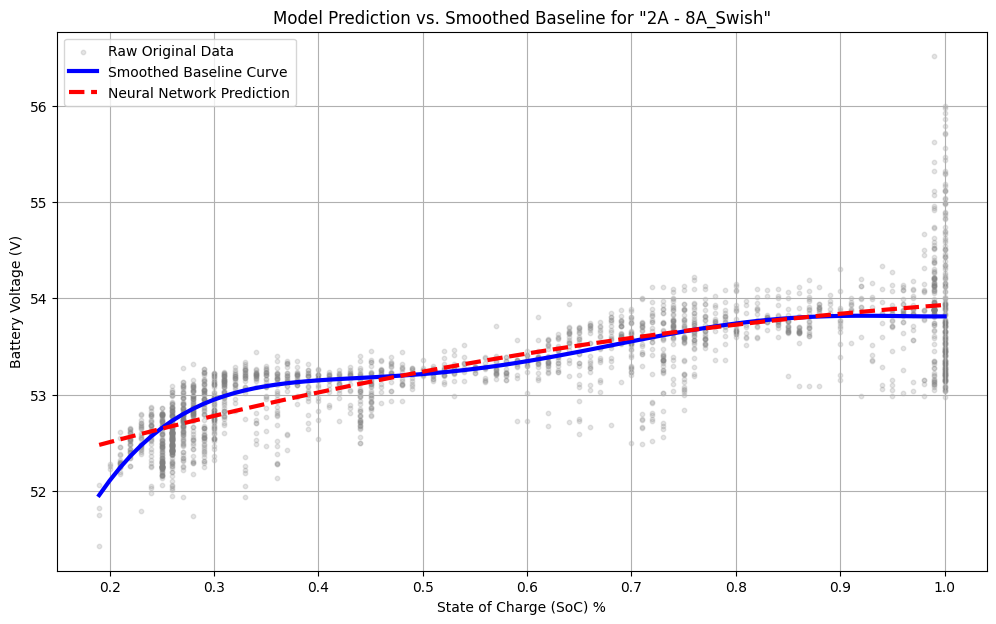

  -> MAE of Model vs. Smoothed Baseline: 0.0616 V
  -> MSE of Model vs. Smoothed Baseline: 0.005151 V²
  -> R2 of Model vs. Smoothed Baseline: 0.972189 V²


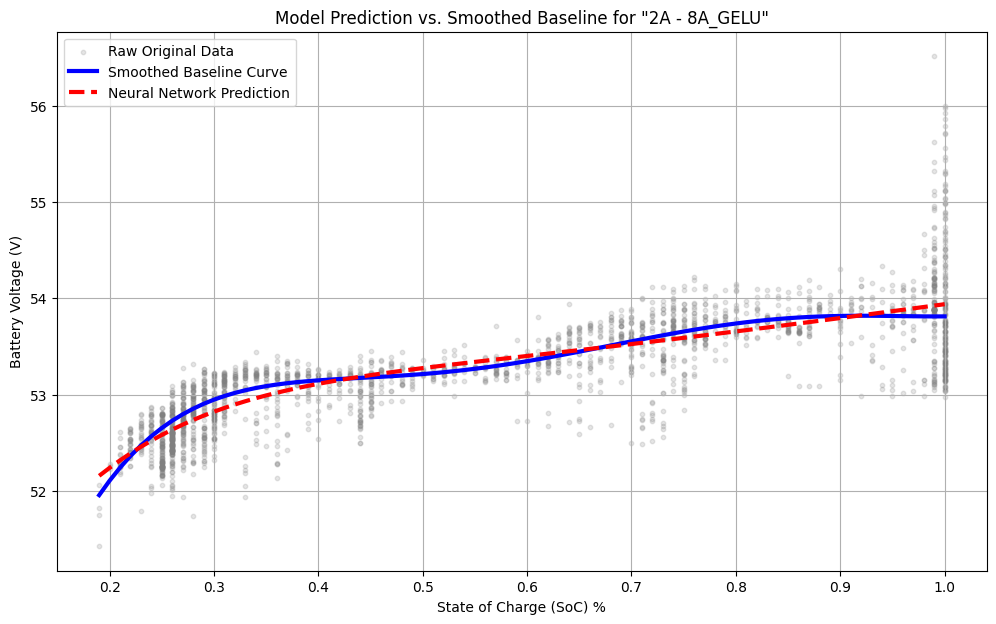

  -> MAE of Model vs. Smoothed Baseline: 0.0565 V
  -> MSE of Model vs. Smoothed Baseline: 0.004833 V²
  -> R2 of Model vs. Smoothed Baseline: 0.973909 V²


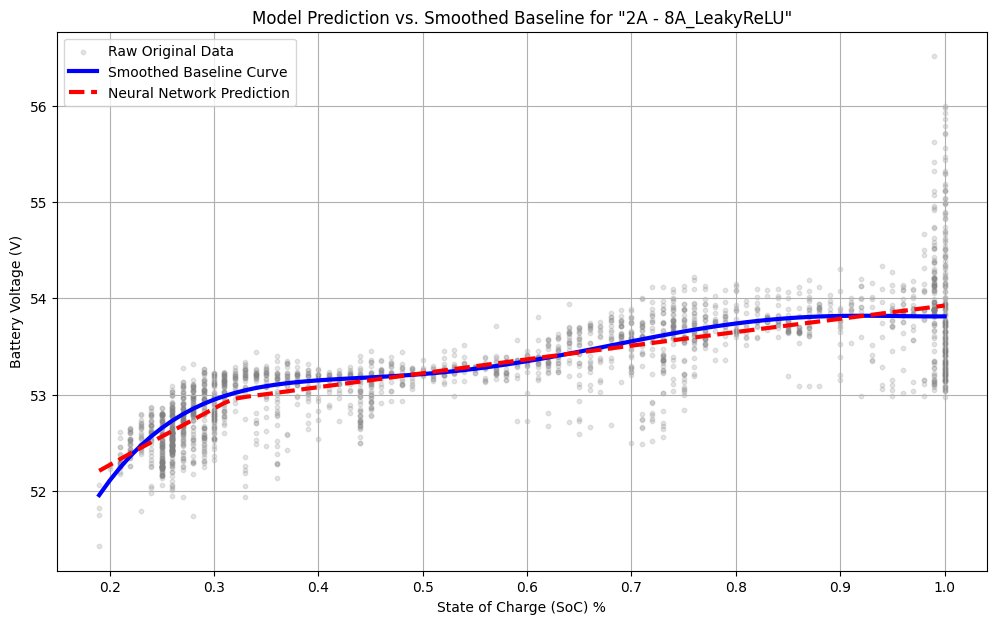

  -> MAE of Model vs. Smoothed Baseline: 0.0728 V
  -> MSE of Model vs. Smoothed Baseline: 0.007276 V²
  -> R2 of Model vs. Smoothed Baseline: 0.953877 V²


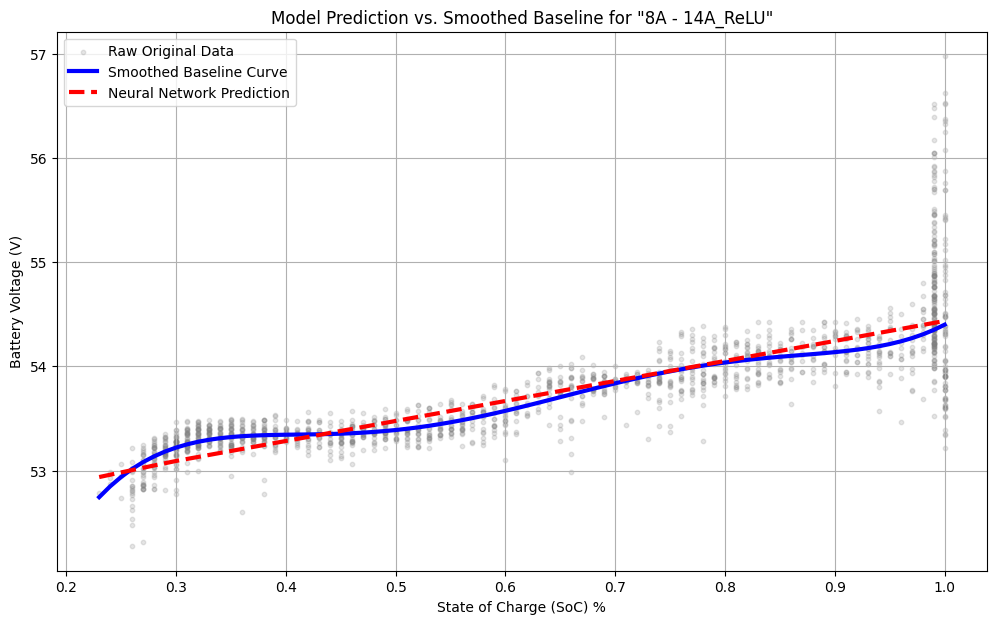

  -> MAE of Model vs. Smoothed Baseline: 0.0659 V
  -> MSE of Model vs. Smoothed Baseline: 0.007654 V²
  -> R2 of Model vs. Smoothed Baseline: 0.951483 V²


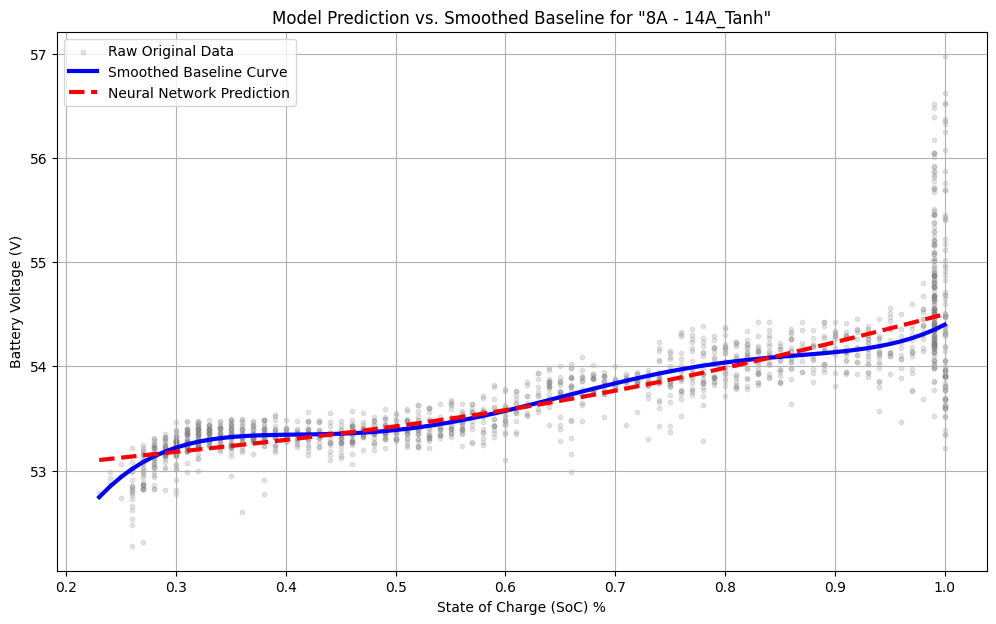

  -> MAE of Model vs. Smoothed Baseline: 0.0649 V
  -> MSE of Model vs. Smoothed Baseline: 0.007222 V²
  -> R2 of Model vs. Smoothed Baseline: 0.954220 V²


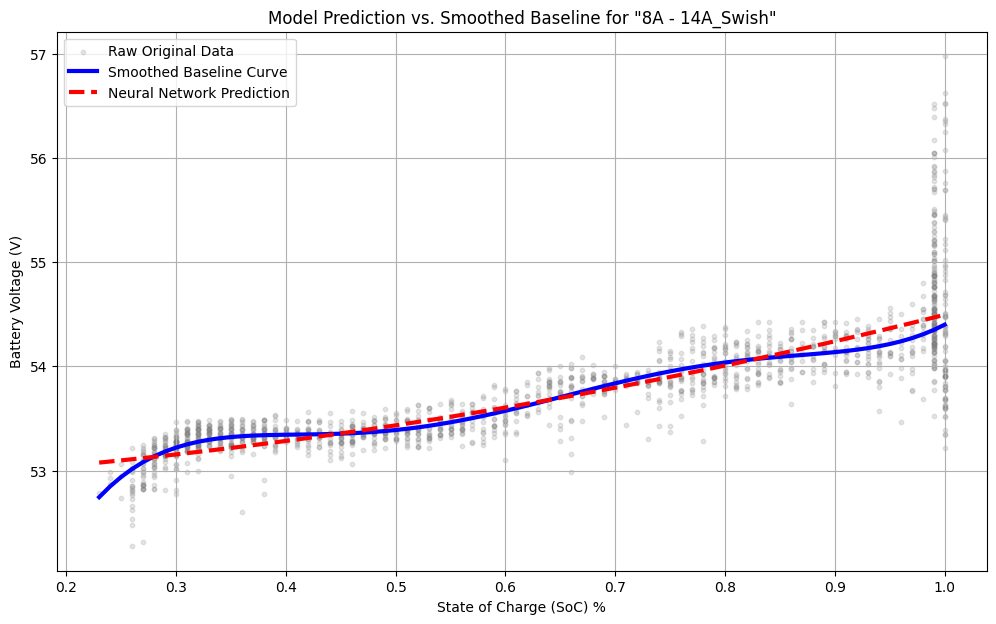

  -> MAE of Model vs. Smoothed Baseline: 0.0694 V
  -> MSE of Model vs. Smoothed Baseline: 0.008693 V²
  -> R2 of Model vs. Smoothed Baseline: 0.944895 V²


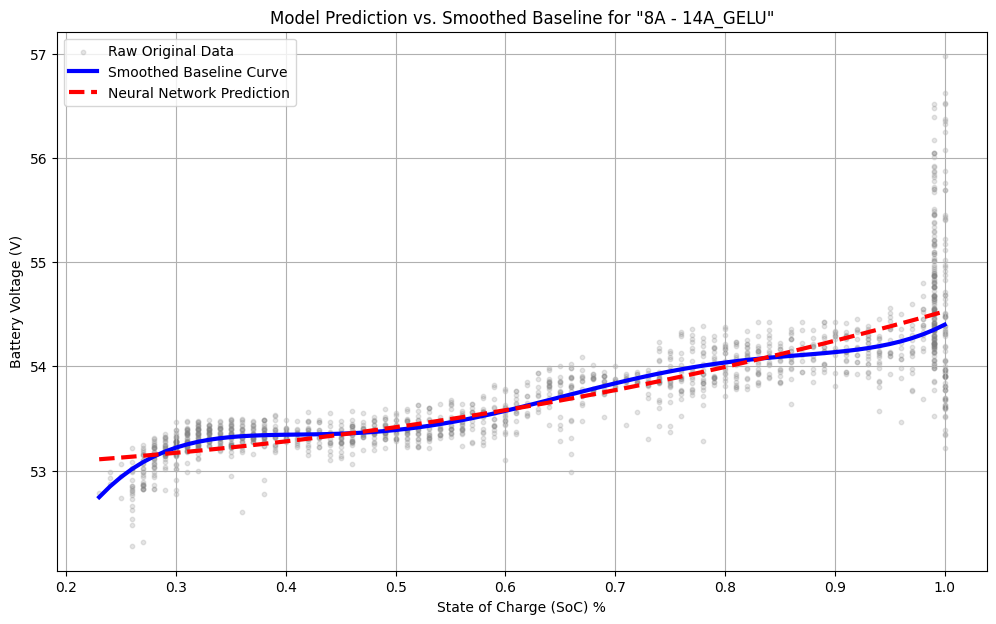

  -> MAE of Model vs. Smoothed Baseline: 0.0517 V
  -> MSE of Model vs. Smoothed Baseline: 0.004943 V²
  -> R2 of Model vs. Smoothed Baseline: 0.968669 V²


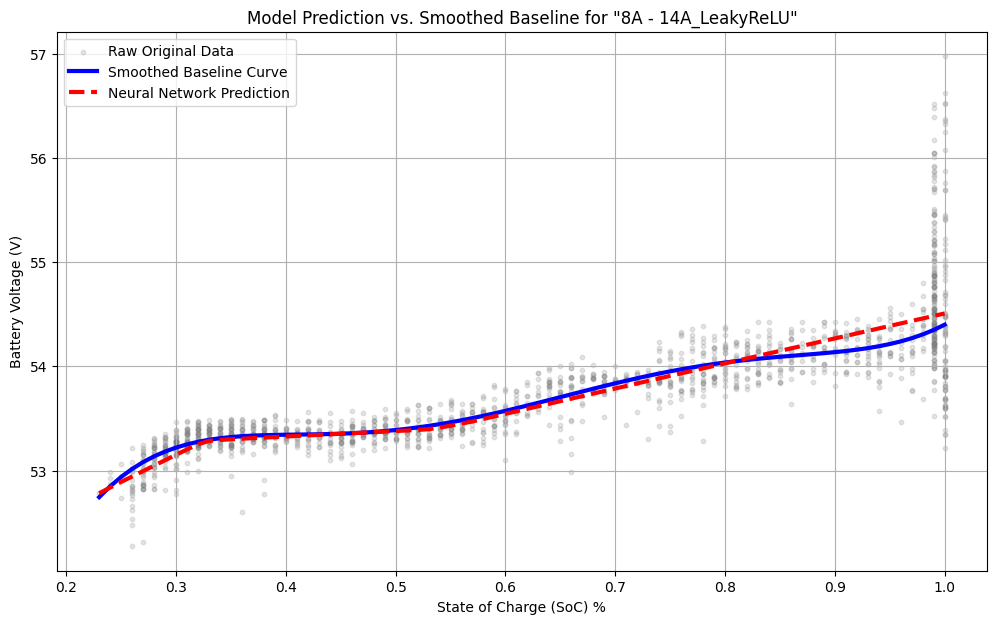

In [7]:
for key, result in benchmark_results.items():
    model = result['model']
    x_scaler = result['x_scaler']
    y_scaler = result['y_scaler']
    original_df = result["df_original"]

    # 2. GENERATE THE SMOOTHED BASELINE DATA
    #    Assuming you have your smoothing functions in a 'processor' object
    smoothed_df = provider.get_smoothed_data(original_df)
    
    # Extract the SoC and the new smoothed Voltage
    soc_for_comparison = smoothed_df[["SoC"]].values
    voltage_smoothed_baseline = smoothed_df["Battery Voltage(V)"].values

    # 3. GET THE MODEL'S PREDICTIONS FOR THE SAME SOC VALUES
    #    CRITICAL: You must scale the input SoC before predicting
    soc_for_comparison_scaled = x_scaler.transform(soc_for_comparison)
    
    # Predict and inverse transform the output to get real voltage
    voltage_model_pred_scaled = model.predict(soc_for_comparison_scaled, verbose=0)
    voltage_model_prediction = y_scaler.inverse_transform(voltage_model_pred_scaled).flatten()

    # 4. CALCULATE THE ERROR AGAINST THE SMOOTHED BASELINE
    mae_vs_smooth = mean_absolute_error(voltage_smoothed_baseline, voltage_model_prediction)
    mse_vs_smooth = mean_squared_error(voltage_smoothed_baseline, voltage_model_prediction)
    r2_vs_smooth = r2_score(voltage_smoothed_baseline, voltage_model_prediction)

    print(f"  -> MAE of Model vs. Smoothed Baseline: {mae_vs_smooth:.4f} V")
    print(f"  -> MSE of Model vs. Smoothed Baseline: {mse_vs_smooth:.6f} V²")
    print(f"  -> R2 of Model vs. Smoothed Baseline: {r2_vs_smooth:.6f} V²")

    # 5. VISUALIZE THE COMPARISON
    plt.figure(figsize=(12, 7))
    
    # Plot the raw, original data points for context
    plt.scatter(original_df["SoC"], original_df["Battery Voltage(V)"],
                label='Raw Original Data', alpha=0.2, color='gray', s=10)

    # Plot your smoothed "ground truth" curve
    plt.plot(soc_for_comparison, voltage_smoothed_baseline,
             label='Smoothed Baseline Curve', color='blue', linewidth=3)
             
    # Plot the Neural Network's prediction
    plt.plot(soc_for_comparison, voltage_model_prediction,
             label='Neural Network Prediction', color='red', linewidth=3, linestyle='--')

    plt.title(f'Model Prediction vs. Smoothed Baseline for "{key}"')
    plt.xlabel('State of Charge (SoC) %')
    plt.ylabel('Battery Voltage (V)')
    plt.legend()
    plt.grid(True)
    plt.show()